In [1]:
import json
from glob import glob
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler

import torchvision
from torchvision import transforms, datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import time

from sklearn.model_selection import train_test_split

In [2]:
training_path = "./Data/Training"
test_path = "./Data/Test"
sign_label_path = "./Data/sign_labels.csv"
batch_size = 64
random_seed = 42
class_count = 43 # 43 classes in GTSRB
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
def showLabelDistribution(dataset, dataloader=None):
    labelDict = dict.fromkeys(range(class_count), 0)
    print(labelDict)
    
    if(dataloader == None):
        for i in range(len(dataset)):
            label = int(dataset[i][1])
            labelDict[label] = labelDict[label] + 1
    else:
        for _, (images, labels) in enumerate(dataloader):
            for label in labels:
                label = int(label)
                labelDict[label] += 1
    
    print(labelDict)
    plt.bar(labelDict.keys(), labelDict.values(), width=1.0, color='g')
    plt.show()
        

In [4]:
def getSignLabels():
    sign_labels = pd.read_csv(sign_label_path)
    sign_object = {}
    for i, row in sign_labels.iterrows():
        sign_object[str(row[0])] = row[1]
    return sign_object

In [5]:
# The German Traffic Sign Recognition Benchmark
#
# sample code for reading the traffic sign images and the
# corresponding labels
#
# example:
#            
# trainImages, trainLabels = readTrafficSigns('GTSRB/Training')
# print len(trainLabels), len(trainImages)
# plt.imshow(trainImages[42])
# plt.show()
#
# have fun, Christian
# Source: http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset#Downloads

# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,class_count):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

In [6]:
class TrafficSignDataset(data.Dataset):
    def __init__(self, images, labels):
        self.images, self.labels = images, labels
        self.transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((32, 32)),
            # Samples are randomly perturbed in position ([-2,2] pixels), 
            # in scale ([.9,1.1] ratio) and rotation ([-15,+15] degrees).
            # Source: http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf
            transforms.RandomApply([
                transforms.RandomRotation(15, resample=Image.BICUBIC),
                transforms.RandomAffine(0, translate=(
                    0.2, 0.2), resample=Image.BICUBIC),
                transforms.RandomAffine(0, shear=20, resample=Image.BICUBIC),
                transforms.RandomAffine(0, scale=(0.9, 1.1),
                                        resample=Image.BICUBIC)
            ]),
            transforms.ToTensor(),
            transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
        ])

    def __getitem__(self, index):
        image = self.transforms(self.images[index])
        labels = np.asarray(self.labels[index])
        labels = torch.from_numpy(labels.astype('int'))
        return image, labels

    def __len__(self):
        return len(self.images)

In [7]:
# Assign Random Seed
np.random.seed(random_seed)

In [8]:
# Loading training data
images, labels = readTrafficSigns(training_path)

# Splitting the data to 8:2 ratios
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=1)

In [9]:
training_dataset = TrafficSignDataset(train_images, train_labels)
validation_dataset = TrafficSignDataset(val_images, val_labels)

In [10]:
print(len(training_dataset))
print(len(validation_dataset))

31367
7842


{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0}
{0: 161, 1: 1774, 2: 1795, 3: 1131, 4: 1582, 5: 1483, 6: 336, 7: 1148, 8: 1142, 9: 1186, 10: 1623, 11: 1077, 12: 1658, 13: 1714, 14: 633, 15: 510, 16: 340, 17: 869, 18: 944, 19: 158, 20: 297, 21: 268, 22: 317, 23: 410, 24: 214, 25: 1204, 26: 471, 27: 200, 28: 452, 29: 215, 30: 348, 31: 621, 32: 193, 33: 562, 34: 345, 35: 969, 36: 301, 37: 172, 38: 1634, 39: 247, 40: 280, 41: 195, 42: 188}


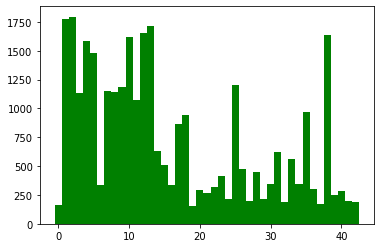

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0}
{0: 49, 1: 446, 2: 455, 3: 279, 4: 398, 5: 377, 6: 84, 7: 292, 8: 268, 9: 284, 10: 387, 11: 243, 12: 442, 13: 446, 14: 147, 15: 120, 16: 80, 17: 241, 18: 256, 19: 52, 20: 63, 21: 62, 22: 73, 23: 100, 24: 56, 25: 296, 26: 129, 27: 40, 28: 88, 29: 55, 30: 102, 31: 159, 32: 47, 33: 127, 34: 75, 35: 231, 36: 89, 37: 38, 38: 436, 39: 53, 40: 80, 41: 45, 42: 52}


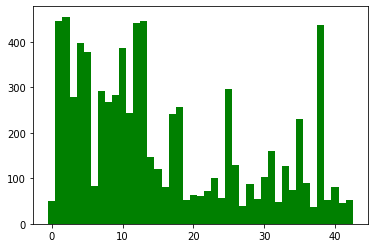

In [11]:
# Check the distribution of labels
showLabelDistribution(training_dataset)
showLabelDistribution(validation_dataset)

In [31]:
# Even out the class distribution for training set
classidx = np.bincount(training_dataset.labels)
weights = 1 / np.array([classidx[int(y)] for y in training_dataset.labels])
sampler = WeightedRandomSampler(weights, len(weights) * class_count)

In [32]:
# Splitting the Dataset into Training Dataloader and the Validation Dataloader
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, sampler=sampler, num_workers=4, drop_last=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, num_workers=4)

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0}
{0: 31481, 1: 31383, 2: 31310, 3: 31367, 4: 31378, 5: 31506, 6: 31104, 7: 31465, 8: 30968, 9: 31592, 10: 31382, 11: 31554, 12: 31331, 13: 31430, 14: 31210, 15: 31158, 16: 31652, 17: 31543, 18: 31154, 19: 31729, 20: 31286, 21: 31366, 22: 31482, 23: 31418, 24: 31439, 25: 31135, 26: 31564, 27: 31290, 28: 31304, 29: 31374, 30: 31316, 31: 31209, 32: 31408, 33: 31101, 34: 31475, 35: 31483, 36: 31080, 37: 31442, 38: 31561, 39: 30940, 40: 31493, 41: 31343, 42: 31530}


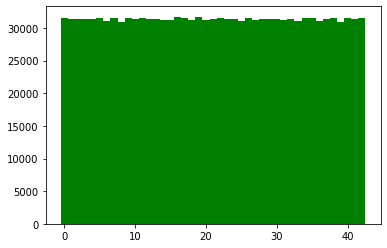

In [14]:
# Make the distribution more even for better training results
showLabelDistribution(_, train_loader)
# showLabelDistribution(_, validation_loader)

In [15]:
for i, (images, labels) in enumerate(train_loader):
    print(images.shape)
    print(labels)
    break

torch.Size([64, 3, 32, 32])
tensor([16, 31, 22, 14,  8, 11,  8, 17,  5, 11, 18, 38, 27, 37, 33, 21, 22,  3,
        20, 23,  3,  1, 13,  1, 28, 25, 14,  2, 12, 19,  8, 20, 18, 11, 40, 19,
        35, 13, 33, 36, 25,  8,  1, 42, 31,  6, 37, 25, 12, 42, 11, 23, 19, 39,
        19,  0, 25, 39, 25, 33, 26, 18, 18, 34])


In [33]:
class TrafficSignNet(nn.Module):
    # Batch shape is (3,32,32)
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        
        # prevent overfitting by dropping randomly
        self.dropout = nn.Dropout(p=0.5)
        
        # convolutional 100 maps of 42x42 neurons 7x7
        self.conv1 = nn.Conv2d(3, 100, 7)
        
        # max pooling 100 maps of 21x21 neurons 2x2
        self.batch1 = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2)
        
        # convolutional 150 maps of 18x18 neurons 4x4
        self.conv2 = nn.Conv2d(100, 150, 4)
        
        # max pooling 150 maps of 9x9 neurons 2x2
        self.batch2 = nn.BatchNorm2d(150)
        # use self.pool; Same pool kernal
        
        # convolutional 250 maps of 6x6 neurons 4x4
        self.conv3 = nn.Conv2d(150, 250, 4)
        
        # max pooling 250 maps of 3x3 neurons 2x2
        self.batch3 = nn.BatchNorm2d(250)
        # use self.pool; Same pool kernal
        
        # fully connected 300 neurons 1x1
        self.fc1 = nn.Linear(250 * 1 * 1, 300)
        self.batch4 = nn.BatchNorm1d(300)
        
        # fully connected 43 neurons 1x1
        self.fc2 = nn.Linear(300, 43)
        
    def forward(self, x):
        ### convolutional 100 maps of 42x42 neurons 7x7
        x = self.conv1(x)
        
        # ELU activation function
        x = F.elu(x)
        
        # max pooling 100 maps of 21x21 neurons 2x2
        x = self.pool(x)
        x = self.batch1(x)
        
        # prevent overfitting by dropping randomly
        x = self.dropout(x)
        
        ### convolutional 150 maps of 18x18 neurons 4x4
        x = self.conv2(x)
        
        # ELU activation function
        x = F.elu(x)
        
        # max pooling 150 maps of 9x9 neurons 2x2
        x = self.pool(x)
        x = self.batch2(x)
        
        # prevent overfitting by dropping randomly
        x = self.dropout(x)

        ### convolutional 250 maps of 6x6 neurons 4x4
        x = self.conv3(x)
        
        # ELU activation function
        x = F.elu(x)
        
        # max pooling 250 maps of 3x3 neurons 2x2
        x = self.pool(x)
        x = self.batch3(x)

        # prevent overfitting by dropping randomly
        x = self.dropout(x)

        ### fully connected 300 neurons 1x1
        x = x.view(-1, 250 * 1 * 1)
        x = self.fc1(x)
        
        # ELU activation function
        x = F.elu(x)
        # prevent overfitting by dropping randomly
        x = self.batch4(x)
        x = self.dropout(x)
        
        ### fully connected 43 neurons 1x1
        x = self.fc2(x)
        
        return x

In [34]:
print(device)

cuda


In [35]:
net = TrafficSignNet()
net.to(device)

TrafficSignNet(
  (dropout): Dropout(p=0.5, inplace=False)
  (conv1): Conv2d(3, 100, kernel_size=(7, 7), stride=(1, 1))
  (batch1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(100, 150, kernel_size=(4, 4), stride=(1, 1))
  (batch2): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(150, 250, kernel_size=(4, 4), stride=(1, 1))
  (batch3): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=250, out_features=300, bias=True)
  (batch4): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=300, out_features=43, bias=True)
)

In [36]:
num_epochs = 100
params = [p for p in net.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)
loss_function = nn.CrossEntropyLoss()

correct = 0
total = 0

consecutive_loss_increase = 0
prev_loss = np.Inf
running_loss = 0

train_losses = []
train_nums = []

val_losses = []
val_nums = []

training_accuracy_epoch = dict.fromkeys(range(100), [])
running_losses_epoch = dict.fromkeys(range(100), [])
training_losses_epoch = dict.fromkeys(range(100), [])
val_losses_epoch = dict.fromkeys(range(100), [])

In [ ]:
for epoch in range(num_epochs):
    t0 = time.time()
    ##### Training
    print("Epoch %d: " % (epoch +1))
    net.train()
    t1 = time.time()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # forward + backward + optimize
        loss = loss_function(net(images), labels)
        loss.backward()
        optimizer.step()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        train_losses.append(loss.item())
        train_nums.append(len(images))
        
        running_loss += loss.item()
        
        if i % 2000 == 1999:
            running_losses_epoch[epoch].append(running_loss / 2000)
            print('[%d, %5d] running loss: %.3f\t took: %.6f seconds' %
                      (epoch + 1, i + 1, running_loss / 2000, time.time() - t1))
            running_loss = 0.0
            t1 = time.time()
       
        
    training_loss = np.sum(np.multiply(train_losses, train_nums)) / np.sum(train_nums)
    training_losses_epoch[epoch].append(training_loss)
    print('[%d] training loss: %.3f\t' %
                  (epoch + 1, training_loss))
    
    ##### Evaluate
    net.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(validation_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            
            loss = loss_function(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            val_losses.append(loss.item())
            val_nums.append(len(images))
            
            if i % 10 == 9:
                validation_accuracy = np.sum(correct) / total
                training_accuracy_epoch[epoch].append(validation_accuracy)
                print('[%d, %5d] Validation Accuracy: %.3f \t' % (epoch + 1, i + 1, validation_accuracy))
    
    val_losses_epoch[epoch].append(new_loss)
    new_loss = np.sum(np.multiply(val_losses, val_nums)) / np.sum(val_nums)
    
    print('Validation Loss: %.3f \t' % (new_loss))
    
    if new_loss <= prev_loss:
        # save progress each valid epoch
        torch.save(net.state_dict(), './checkpoint/' + str(epoch) + '.pth')
    
        prev_loss = new_loss
        consecutive_loss_increase = 0
    else:
        consecutive_loss_increase += 1
        
        if(consecutive_loss_increase > 9):
            print("Ending training due to consecutive non-decrease of loss")
    
    print('Epoch %d: took: %.3f seconds' % (epoch + 1, time.time() - t0))
          
torch.save(net.state_dict(), './final_model.pth')

Epoch 1: 
[1,  2000] running loss: 3.324	 took: 55.365425 seconds
[1,  4000] running loss: 2.692	 took: 55.085633 seconds
[1,  6000] running loss: 2.325	 took: 55.110111 seconds
[1,  8000] running loss: 2.056	 took: 55.239632 seconds
[1, 10000] running loss: 1.861	 took: 55.045239 seconds
[1, 12000] running loss: 1.715	 took: 54.935344 seconds
[1, 14000] running loss: 1.588	 took: 54.999887 seconds
[1, 16000] running loss: 1.490	 took: 54.999984 seconds
[1, 18000] running loss: 1.395	 took: 55.085250 seconds
[1, 20000] running loss: 1.328	 took: 55.166181 seconds
[1] training loss: 1.942	
[1,    10] Validation Accuracy: 0.706 	
[1,    20] Validation Accuracy: 0.715 	
[1,    30] Validation Accuracy: 0.714 	
[1,    40] Validation Accuracy: 0.715 	
[1,    50] Validation Accuracy: 0.712 	
[1,    60] Validation Accuracy: 0.711 	
[1,    70] Validation Accuracy: 0.709 	
[1,    80] Validation Accuracy: 0.706 	
[1,    90] Validation Accuracy: 0.708 	
[1,   100] Validation Accuracy: 0.708 	
[1, 

[8, 12000] running loss: 0.314	 took: 54.374440 seconds
[8, 14000] running loss: 0.314	 took: 54.559377 seconds
[8, 16000] running loss: 0.303	 took: 54.652973 seconds
[8, 18000] running loss: 0.307	 took: 54.366357 seconds
[8, 20000] running loss: 0.302	 took: 54.194113 seconds
[8] training loss: 0.747	
[8,    10] Validation Accuracy: 0.888 	
[8,    20] Validation Accuracy: 0.889 	
[8,    30] Validation Accuracy: 0.890 	
[8,    40] Validation Accuracy: 0.891 	
[8,    50] Validation Accuracy: 0.892 	
[8,    60] Validation Accuracy: 0.893 	
[8,    70] Validation Accuracy: 0.894 	
[8,    80] Validation Accuracy: 0.894 	
[8,    90] Validation Accuracy: 0.895 	
[8,   100] Validation Accuracy: 0.896 	
[8,   110] Validation Accuracy: 0.897 	
[8,   120] Validation Accuracy: 0.897 	
Validation Loss: 0.395 	
Epoch 8: took: 577.983 seconds
Epoch 9: 
[9,  2000] running loss: 0.457	 took: 55.269054 seconds
[9,  4000] running loss: 0.299	 took: 54.726003 seconds
[9,  6000] running loss: 0.294	 took

[15, 18000] running loss: 0.182	 took: 54.482610 seconds
[15, 20000] running loss: 0.182	 took: 54.423307 seconds
[15] training loss: 0.505	
[15,    10] Validation Accuracy: 0.934 	
[15,    20] Validation Accuracy: 0.934 	
[15,    30] Validation Accuracy: 0.934 	
[15,    40] Validation Accuracy: 0.934 	
[15,    50] Validation Accuracy: 0.935 	
[15,    60] Validation Accuracy: 0.935 	
[15,    70] Validation Accuracy: 0.935 	
[15,    80] Validation Accuracy: 0.936 	
[15,    90] Validation Accuracy: 0.936 	
[15,   100] Validation Accuracy: 0.936 	
[15,   110] Validation Accuracy: 0.936 	
[15,   120] Validation Accuracy: 0.937 	
Validation Loss: 0.249 	
Epoch 15: took: 576.754 seconds
Epoch 16: 
[16,  2000] running loss: 0.283	 took: 55.011872 seconds
[16,  4000] running loss: 0.179	 took: 54.319456 seconds
[16,  6000] running loss: 0.179	 took: 54.165416 seconds
[16,  8000] running loss: 0.177	 took: 54.027640 seconds
[16, 10000] running loss: 0.177	 took: 54.321780 seconds
[16, 12000] ru

[22] training loss: 0.394	
[22,    10] Validation Accuracy: 0.952 	
[22,    20] Validation Accuracy: 0.953 	
[22,    30] Validation Accuracy: 0.953 	
[22,    40] Validation Accuracy: 0.953 	
[22,    50] Validation Accuracy: 0.953 	
[22,    60] Validation Accuracy: 0.953 	
[22,    70] Validation Accuracy: 0.953 	
[22,    80] Validation Accuracy: 0.953 	
[22,    90] Validation Accuracy: 0.954 	
[22,   100] Validation Accuracy: 0.954 	
[22,   110] Validation Accuracy: 0.954 	
[22,   120] Validation Accuracy: 0.954 	
Validation Loss: 0.185 	
Epoch 22: took: 574.367 seconds
Epoch 23: 
[23,  2000] running loss: 0.215	 took: 54.923558 seconds
[23,  4000] running loss: 0.137	 took: 54.172319 seconds
[23,  6000] running loss: 0.136	 took: 54.204645 seconds
[23,  8000] running loss: 0.135	 took: 54.276155 seconds
[23, 10000] running loss: 0.138	 took: 54.167450 seconds
[23, 12000] running loss: 0.137	 took: 54.254482 seconds
[23, 14000] running loss: 0.138	 took: 53.993859 seconds
[23, 16000] ru

[29,    30] Validation Accuracy: 0.963 	
[29,    40] Validation Accuracy: 0.963 	
[29,    50] Validation Accuracy: 0.963 	
[29,    60] Validation Accuracy: 0.963 	
[29,    70] Validation Accuracy: 0.963 	
[29,    80] Validation Accuracy: 0.963 	
[29,    90] Validation Accuracy: 0.963 	
[29,   100] Validation Accuracy: 0.963 	
[29,   110] Validation Accuracy: 0.963 	
[29,   120] Validation Accuracy: 0.963 	
Validation Loss: 0.149 	
Epoch 29: took: 574.805 seconds
Epoch 30: 
[30,  2000] running loss: 0.179	 took: 55.038982 seconds
[30,  4000] running loss: 0.117	 took: 54.273346 seconds
[30,  6000] running loss: 0.115	 took: 54.285881 seconds
[30,  8000] running loss: 0.118	 took: 54.029412 seconds
[30, 10000] running loss: 0.115	 took: 54.358524 seconds
[30, 12000] running loss: 0.116	 took: 54.018037 seconds
[30, 14000] running loss: 0.116	 took: 54.056886 seconds
[30, 16000] running loss: 0.116	 took: 54.105996 seconds
[30, 18000] running loss: 0.118	 took: 54.302525 seconds
[30, 2000

[36,    60] Validation Accuracy: 0.969 	
[36,    70] Validation Accuracy: 0.969 	
[36,    80] Validation Accuracy: 0.969 	
[36,    90] Validation Accuracy: 0.969 	
[36,   100] Validation Accuracy: 0.969 	
[36,   110] Validation Accuracy: 0.969 	
[36,   120] Validation Accuracy: 0.969 	
Validation Loss: 0.126 	
Epoch 36: took: 574.077 seconds
Epoch 37: 
[37,  2000] running loss: 0.161	 took: 54.830596 seconds
[37,  4000] running loss: 0.105	 took: 54.244827 seconds
[37,  6000] running loss: 0.107	 took: 53.953705 seconds
[37,  8000] running loss: 0.106	 took: 54.071836 seconds
[37, 10000] running loss: 0.105	 took: 54.028186 seconds
[37, 12000] running loss: 0.104	 took: 54.085144 seconds
[37, 14000] running loss: 0.103	 took: 54.196444 seconds
[37, 16000] running loss: 0.104	 took: 54.176471 seconds
[37, 18000] running loss: 0.105	 took: 54.360901 seconds
[37, 20000] running loss: 0.104	 took: 54.260411 seconds
[37] training loss: 0.282	
[37,    10] Validation Accuracy: 0.970 	
[37,   

[43,    90] Validation Accuracy: 0.974 	
[43,   100] Validation Accuracy: 0.974 	
[43,   110] Validation Accuracy: 0.974 	
[43,   120] Validation Accuracy: 0.974 	
Validation Loss: 0.110 	
Epoch 43: took: 574.933 seconds
Epoch 44: 
[44,  2000] running loss: 0.146	 took: 54.955018 seconds
[44,  4000] running loss: 0.099	 took: 54.116808 seconds
[44,  6000] running loss: 0.097	 took: 54.005776 seconds
[44,  8000] running loss: 0.097	 took: 54.090370 seconds
[44, 10000] running loss: 0.097	 took: 54.006252 seconds
[44, 12000] running loss: 0.098	 took: 53.964926 seconds
[44, 14000] running loss: 0.097	 took: 54.019566 seconds
[44, 16000] running loss: 0.096	 took: 54.099744 seconds
[44, 18000] running loss: 0.097	 took: 53.946722 seconds
[44, 20000] running loss: 0.096	 took: 54.189907 seconds
[44] training loss: 0.253	
[44,    10] Validation Accuracy: 0.974 	
[44,    20] Validation Accuracy: 0.974 	
[44,    30] Validation Accuracy: 0.974 	
[44,    40] Validation Accuracy: 0.974 	
[44,   

In [39]:
# Check dataloaders have about the same sizes
print(len(train_loader) * batch_size)
print(len(validation_loader) * batch_size)

1348736
7872


In [41]:
print("Training Accuracy per Epoch: ")
print(training_accuracy_epoch)

Training Accuracy per Epoch: 
{0: [0.70625, 0.71484375, 0.7140625, 0.71484375, 0.7115625, 0.7109375, 0.7089285714285715, 0.70625, 0.7079861111111111, 0.7078125, 0.7085227272727272, 0.7092447916666667, 0.7175194529592077, 0.725279543959658, 0.7327391927883631, 0.7392809075177851, 0.7449737366419127, 0.7499571991097415, 0.7540983606557377, 0.7589878105230674, 0.7626819585355095, 0.7666760286476618, 0.7689826636204811, 0.7709058111068161, 0.7758515069835824, 0.7792383871728366, 0.7837423312883436, 0.7873821530366147, 0.7909870790086846, 0.7937410366728129, 0.7964689545725054, 0.7993655066333397, 0.8017627308337997, 0.8038851657308459, 0.8054919908466819, 0.8072247902756378, 0.8108913349333775, 0.813472546964444, 0.8160025151300794, 0.8188683585064785, 0.8212976128114944, 0.8233574508514214, 0.8256445047489823, 0.8278642742442226, 0.8297821484668442, 0.8316179910445767, 0.833344238696591, 0.834807408831635, 0.8376343414146463, 0.8399901984807645, 0.8417447728911319, 0.8435805234614477, 0.8

In [42]:
print("Running Losses per Epoch: ")
print(running_losses_epoch)

Running Losses per Epoch: 
{0: [3.3236231408119203, 2.6918336024284364, 2.3253245211839677, 2.0561197116374967, 1.861498900771141, 1.715467371404171, 1.5881782785654068, 1.4900271736979485, 1.3952609311640263, 1.3284991310536862, 1.9179649313688278, 1.17963320595026, 1.1361526203751564, 1.0934626911878587, 1.0484407093822956, 1.021245298922062, 0.9851649423837662, 0.9519699886739253, 0.9240478417873382, 0.9020081010758877, 1.338083705842495, 0.8450663475543261, 0.8216454656869173, 0.7980284246504307, 0.7793758744001389, 0.7668967833667993, 0.7470160117149353, 0.7288066870421172, 0.7147396077364683, 0.7018661751747132, 1.048049973361194, 0.6593756752461195, 0.6455406232476234, 0.6378487265408039, 0.6253512677103281, 0.6138014348447323, 0.6033204234540462, 0.5871552707850933, 0.5812758891060948, 0.5680972764790058, 0.8524491767063737, 0.5449500529766083, 0.5306973703727126, 0.5234386239051819, 0.5083112017810345, 0.5026257049664855, 0.4888689997345209, 0.4863431327790022, 0.4765993840992

In [43]:
print("Training Losses per Epoch: ")
print(training_losses_epoch)

Training Losses per Epoch: 
{0: [1.9418316840463654, 1.4905448458891526, 1.2509817034729704, 1.0925483874906987, 0.9752300923583607, 0.8828826599190285, 0.8083090759713986, 0.7468020824450425, 0.6955471692669207, 0.6520036358369308, 0.6145306631751221, 0.5818708589915119, 0.5531130803994964, 0.5276253538361754, 0.504859111735206, 0.4844260854561205, 0.46587034969877145, 0.4489641926883478, 0.43354388940962246, 0.41935266011680133, 0.4063026676945991, 0.394240746964973, 0.3830548974879924, 0.37263344730285775, 0.36289787049870276, 0.3537838006303912, 0.34526440790020985, 0.33724743308365035, 0.329700922299454, 0.32257922664668304, 0.3158487592833888, 0.3094889192939481, 0.3034531105601923, 0.29772204091755, 0.2922621523187644, 0.2870750406325929, 0.2821453893796239, 0.27743593258619054, 0.27293663108191896, 0.2686364205854242, 0.26450860636299556, 0.26054683469970324, 0.25676585705993055, 0.25313118412569613, 0.2496311626093389, 0.24626444918363927, 0.2430288129881979, 0.239907569646921

In [44]:
print("Validation Losses per Epoch: ")
print(val_losses_epoch)

Validation Losses per Epoch: 
{0: [0.1806653093482973, 1.0614973880660319, 0.8443645154508636, 0.7149525179421528, 0.6173405072760351, 0.5411769994224587, 0.4812125880456463, 0.43346169025132614, 0.39490071685404704, 0.3643318631799832, 0.3376575188169261, 0.3150628462982447, 0.2955364056362591, 0.2779867451242528, 0.2624383342339728, 0.249120063329953, 0.23721377203004418, 0.22630373425427122, 0.21646795469638683, 0.2074494333210823, 0.19918178853238497, 0.19174778363926498, 0.18485254165027115, 0.17842476071964739, 0.17253566325104697, 0.16704149591307293, 0.16209541579388423, 0.1574760657739242, 0.15319249637418805, 0.1491015901507434, 0.14526462134967943, 0.1415664351889811, 0.13808593814078307, 0.13466944911986137, 0.1318911418606513, 0.12890389616586137, 0.12602070791801767, 0.12333891688353078, 0.1207916484260826, 0.11835462717246556, 0.11606802879114479, 0.11391088149043467, 0.11180555124626614, 0.10980847770739041, 0.10783615059688018, 0.10595760314857744, 0.10414437882162551,

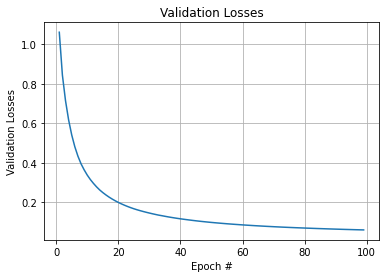

In [72]:
### Visualizing
fig, ax = plt.subplots()

x_val_loss = np.arange(1, 100, 1)
y_val_loss = val_losses_epoch[99][1:]
    
ax.plot(x_val_loss, y_val_loss)

ax.set(xlabel='Epoch #', ylabel='Validation Losses',
       title='Validation Losses')
ax.grid()

fig.savefig("validation_loss.png")
plt.show()

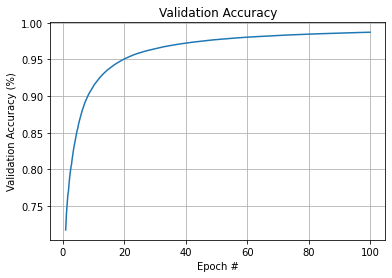

In [92]:
### Visualizing
fig, ax = plt.subplots()

x_val_acc = np.arange(1, 100, 1/12)
y_val_acc = training_accuracy_epoch[99][12:]
    
ax.plot(x_val_acc, y_val_acc)

ax.set(xlabel='Epoch #', ylabel='Validation Accuracy (%)',
       title='Validation Accuracy')
ax.grid()

fig.savefig("validation_accuracy.png")
plt.show()

26640
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0}
{0: 150, 1: 1500, 2: 1500, 3: 960, 4: 1320, 5: 1260, 6: 300, 7: 960, 8: 960, 9: 990, 10: 1350, 11: 900, 12: 1410, 13: 1440, 14: 540, 15: 420, 16: 300, 17: 750, 18: 810, 19: 150, 20: 240, 21: 240, 22: 270, 23: 360, 24: 180, 25: 1020, 26: 420, 27: 180, 28: 360, 29: 180, 30: 300, 31: 540, 32: 180, 33: 480, 34: 300, 35: 810, 36: 270, 37: 150, 38: 1380, 39: 210, 40: 240, 41: 180, 42: 180}


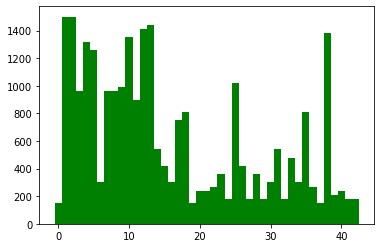

In [93]:
# Make Testset
test_images, test_labels = readTrafficSigns(test_path)
test_dataset = TrafficSignDataset(test_images, test_labels)

print(len(test_dataset))
showLabelDistribution(test_dataset)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

In [95]:
len(test_loader)

417

In [97]:
# Test against testset
net.eval()

correct_test = 0
total_test = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        if i % 50 == 49:
            test_accuracy = np.sum(correct_test) / total_test
            print('[%5d] Test Accuracy: %.3f \t' % (i + 1, test_accuracy))
            
print('Accuracy of the network on the 26640 test images: %.6f %%' % (
    100 * correct_test / total_test))

[   50] Test Accuracy: 0.997 	
[  100] Test Accuracy: 0.996 	
[  150] Test Accuracy: 0.996 	
[  200] Test Accuracy: 0.996 	
[  250] Test Accuracy: 0.997 	
[  300] Test Accuracy: 0.997 	
[  350] Test Accuracy: 0.998 	
[  400] Test Accuracy: 0.998 	
Accuracy of the network on the 26640 test images: 99.786036 %
